# MCSM-Benchs: Querying Signal class attributes for more versatile benchmarks

The `SignalBank` class encapsulates the signal generation code and yields a dictionary with a number of signals. In order to access those signals, the keys of this dictionary are called `signal_id`. The constructor simply takes the number `N` of samples of the desired signals.

Within the `Benchmark` class, the signals obtained from the `SignalBank` class are given as objects of another custom class called `Signal`.
This class behaves like a regular `numpy` array, but it also comprises a series of attributes of the signal that some methods might need. Moreover, benchmarks can be built to estimate these quantities as well.

Let's see some examples.

In [1]:
import numpy as np
import scipy.signal as sg
from numpy import pi as pi
from matplotlib import pyplot as plt
from mcsm_benchs.SignalBank import SignalBank
from mcsm_benchs.Benchmark import Benchmark
from mcsm_benchs.ResultsInterpreter import ResultsInterpreter
from utils import get_stft

plt.rcParams['image.cmap'] = 'binary'

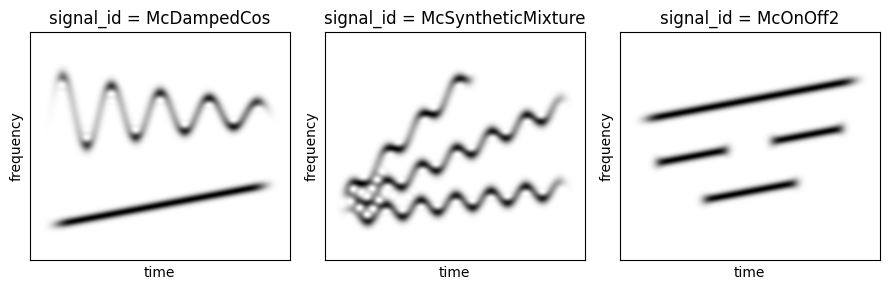

In [2]:
# Set the length of the signals to generate
N = 1024

# The second parameter makes it return objects of the Signal class
signal_bank = SignalBank(N=N, return_signal=True) 
signal_dic = signal_bank.generate_signal_dict()

# Select three signals as examples:
signal_ids = ['McDampedCos','McSyntheticMixture', 'McOnOff2']

# Plot the spectrograms of some signals:
fig, ax = plt.subplots(1, 3, layout='tight', figsize=(9,3))

for i,signal_id in enumerate(signal_ids):
    signal = signal_dic[signal_id]
    S = np.abs(get_stft(signal))**2
    idx = np.unravel_index(i, ax.shape)
    ax[idx].imshow(S, origin = 'lower',aspect='auto')
    ax[idx].set_title('signal_id = '+ signal_id)
    ax[idx].set_xticks([],[])
    ax[idx].set_xlabel('time')
    ax[idx].set_yticks([])
    ax[idx].set_ylabel('frequency')

We can now query a `Signal` instance to obtain:
- Total number of components
- Number of components at each time instant
- Instantaneous frequency of each component
- Each individual component

Total number of components: 4


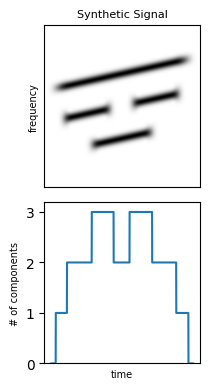

In [3]:
signal_1 = signal_dic[signal_ids[2]]
print('Total number of components: {}'.format(signal_1.total_comps))

fig, axs = plt.subplots(2, 1, layout='tight', figsize=(2.2,4))
S = np.abs(get_stft(signal_1))
axs[0].imshow(S, origin = 'lower',aspect='auto')
# axs[0].set_title('signal_id = '+ signal_ids[2])
axs[0].set_title('Synthetic Signal', fontsize=8)
axs[0].set_xticks([],[])
# axs[0].set_xlabel('time')
axs[0].set_yticks([])
axs[0].set_ylabel('frequency',fontsize=7)

# Plot the instantaneous frequencies on top
# for instafreq in signal_1.instf:
#     axs[0].plot(instafreq*2*N,'--')

axs[1].plot(signal_1.ncomps)
axs[1].set_xlabel('time', fontsize=7)
axs[1].set_ylabel('# of components',fontsize=7)
axs[1].set_ylim([0,3.2])
axs[1].set_yticks([0,1,2,3])
axs[1].set_xticks([],[])


fig.savefig('signals_ncomps.pdf',dpi=900, transparent=False,bbox_inches='tight')

We can also get the separated components of a signal

<class 'mcsm_benchs.SignalBank.Signal'>
Total number of components: 3


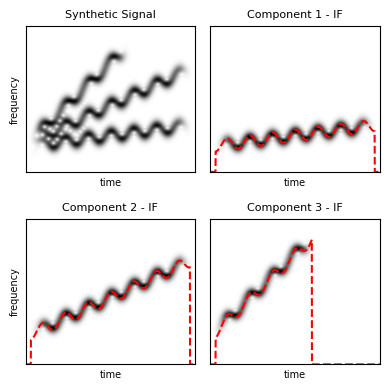

In [4]:
signal_2 = signal_dic[signal_ids[1]]
print(type(signal_2))
print('Total number of components: {}'.format(signal_2.total_comps))

# Plot the spectrograms of some signals:
fig, ax = plt.subplots(2, 2, sharex=True,sharey=True, layout='tight', figsize=(4,4))
idx = np.unravel_index(0, ax.shape)
S = np.abs(get_stft(signal_2))
ax[idx].imshow(S, origin = 'lower',aspect='auto')
ax[idx].set_title('Synthetic Signal',fontsize=8)
ax[idx].set_xticks([],[])
ax[idx].set_xlabel('time', fontsize=7)
ax[idx].set_yticks([])
ax[idx].set_ylabel('frequency', fontsize=7)


for i in range(1,signal_2.total_comps+1):
    component = signal_2.comps[i-1]
    S = np.abs(get_stft(component))
    idx = np.unravel_index(i, ax.shape)    
    ax[idx].imshow(S, origin = 'lower',aspect='auto')
    ax[idx].set_title('Component {} - IF'.format(i),fontsize=8)
    ax[idx].set_xticks([],[])
    ax[idx].set_xlabel('time', fontsize=7)
    ax[idx].set_yticks([])
    if np.mod(i,2)==0:
        ax[idx].set_ylabel('frequency', fontsize=7)
    ax[idx].plot(signal_2.instf[i-1]*2*N,'r--') 

fig.savefig('signals_ifs.pdf',dpi=900, transparent=False,bbox_inches='tight')

### Benchmarking a component counting method

In [5]:
methods = {'fun1': lambda x,*args,**kwargs: 4,
            'fun2': lambda x,*args,**kwargs: x.total_comps,
            }

perf_fun = {'Error': lambda x, x_hat, *args, **kwargs: x.total_comps-x_hat,}


benchmark = Benchmark(task = 'misc',
                        methods = methods,
                        N = 256, 
                        SNRin = [10,20], 
                        repetitions = 3,
                        obj_fun=perf_fun,
                        signal_ids=['LinearChirp', 'CosChirp',],
                        verbosity=0, 
                        parallelize=False,
                        )
                        
benchmark.run_test() # Run the test. my_results is a dictionary with the results for each of the variables of the simulation.
benchmark.save_to_file('saved_benchmark') # Save the benchmark to a file.


Running benchmark...


100%|██████████| 2/2 [00:00<00:00, 3536.51it/s]


True

In [6]:
benchmark = Benchmark.load_benchmark('saved_benchmark')
results_df = benchmark.get_results_as_df() # This formats the results on a DataFrame
results_df

,Method,Parameter,Signal_id,Repetition,10,20
6,fun1,"((), {})",CosChirp,0,-3,-3
7,fun1,"((), {})",CosChirp,1,-3,-3
8,fun1,"((), {})",CosChirp,2,-3,-3
0,fun1,"((), {})",LinearChirp,0,-3,-3
1,fun1,"((), {})",LinearChirp,1,-3,-3
2,fun1,"((), {})",LinearChirp,2,-3,-3
9,fun2,"((), {})",CosChirp,0,0,0
10,fun2,"((), {})",CosChirp,1,0,0
11,fun2,"((), {})",CosChirp,2,0,0
3,fun2,"((), {})",LinearChirp,0,0,0
